# Can sentiment be a good predictor of how the Dow Jones will do that day

### 1.1 Import libaries

In [151]:
import os
import re
import time

import numpy as np
import pandas as pd
# import seaborn as sns
import matplotlib.pyplot as plt


import nltk
nltk.download("stopwords", quiet=True)
from nltk.corpus import stopwords
from nltk.stem.porter import *

from bs4 import BeautifulSoup
from wordcloud import WordCloud
import pickle

from imblearn.under_sampling import ClusterCentroids
from imblearn.under_sampling import TomekLinks

from sklearn.model_selection import TimeSeriesSplit

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

### 1.2 Retrieve Data

In [8]:
data = pd.read_csv('./data/Combined_News_DJIA.csv', encoding='utf-8')

In [9]:
data.head()
data.shape

(1989, 27)

In [10]:
#Remove byte String, newline tabs and the rest
data = data.replace({"b'": "", 'b"': '', '\n': '', '\t': ''}, regex=True)
data.head()

,Date,Label,Top1,Top2,Top3,Top4,Top5,Top6,Top7,Top8,...,Top16,Top17,Top18,Top19,Top20,Top21,Top22,Top23,Top24,Top25
0,2008-08-08,0,Georgia 'downs two Russian warplanes' as count...,BREAKING: Musharraf to be impeached.',Russia Today: Columns of troops roll into Sout...,Russian tanks are moving towards the capital o...,"Afghan children raped with 'impunity,' U.N. of...",150 Russian tanks have entered South Ossetia w...,"Breaking: Georgia invades South Ossetia, Russi...",The 'enemy combatent' trials are nothing but a...,...,Georgia Invades South Ossetia - if Russia gets...,Al-Qaeda Faces Islamist Backlash',"Condoleezza Rice: ""The US would not act to pre...",This is a busy day: The European Union has ap...,"Georgia will withdraw 1,000 soldiers from Iraq...",Why the Pentagon Thinks Attacking Iran is a Ba...,Caucasus in crisis: Georgia invades South Osse...,Indian shoe manufactory - And again in a seri...,Visitors Suffering from Mental Illnesses Banne...,"No Help for Mexico's Kidnapping Surge"""
1,2008-08-11,1,Why wont America and Nato help us? If they won...,Bush puts foot down on Georgian conflict',Jewish Georgian minister: Thanks to Israeli tr...,Georgian army flees in disarray as Russians ad...,"Olympic opening ceremony fireworks 'faked'""",What were the Mossad with fraudulent New Zeala...,Russia angered by Israeli military sale to Geo...,An American citizen living in S.Ossetia blames...,...,Israel and the US behind the Georgian aggressi...,"""Do not believe TV, neither Russian nor Georgi...",Riots are still going on in Montreal (Canada) ...,China to overtake US as largest manufacturer',War in South Ossetia [PICS]',Israeli Physicians Group Condemns State Torture',Russia has just beaten the United States over...,Perhaps *the* question about the Georgia - Rus...,Russia is so much better at war',So this is what it's come to: trading sex for ...
2,2008-08-12,0,Remember that adorable 9-year-old who sang at ...,"Russia 'ends Georgia operation'""","""If we had no sexual harassment we would have ...",Al-Qa'eda is losing support in Iraq because of...,Ceasefire in Georgia: Putin Outmaneuvers the W...,Why Microsoft and Intel tried to kill the XO $...,Stratfor: The Russo-Georgian War and the Balan...,I'm Trying to Get a Sense of This Whole Georgi...,...,U.S. troops still in Georgia (did you know the...,Why Russias response to Georgia was right',"Gorbachev accuses U.S. of making a ""serious bl...","Russia, Georgia, and NATO: Cold War Two'",Remember that adorable 62-year-old who led you...,War in Georgia: The Israeli connection',All signs point to the US encouraging Georgia ...,Christopher King argues that the US and NATO a...,America: The New Mexico?',BBC NEWS | Asia-Pacific | Extinction 'by man n...
3,2008-08-13,0,U.S. refuses Israel weapons to attack Iran: r...,When the president ordered to attack Tskhinval...,Israel clears troops who killed Reuters camer...,"Britain\'s policy of being tough on drugs is ""...",Body of 14 year old found in trunk; Latest (ra...,China has moved 10 *million* quake survivors i...,Bush announces Operation Get All Up In Russia'...,Russian forces sink Georgian ships ',...,Elephants extinct by 2020?',US humanitarian missions soon in Georgia - if ...,"Georgia's DDOS came from US sources""","Russian convoy heads into Georgia, violating t...",Israeli defence minister: US against strike on...,Gorbachev: We Had No Choice',Witness: Russian forces head towards Tbilisi i...,Quarter of Russians blame U.S. for conflict: ...,Georgian president says US military will take...,2006: Nobel laureate Aleksander Solzhenitsyn a...
4,2008-08-14,1,All the experts admit that we should legalise ...,War in South Osetia - 89 pictures made by a Ru...,Swedish wrestler Ara Abrahamian throws away me...,Russia exaggerated the death toll in South Oss...,Missile That Killed 9 Inside Pakistan May Have...,Rushdie Condemns Random House's Refusal to Pub...,Poland and US agree to missle defense deal. In...,"Will the Russians conquer Tblisi? Bet on it,

In [11]:
clean_df = data.iloc[:,0:2] 
clean_df['Combined'] = data.iloc[:,2:].apply(lambda row: ''.join(str(row.values)), axis=1)
clean_df['Combined'] = clean_df['Combined'].replace('[^a-zA-Z ]', '', regex=True)
#clean_df['Combined'] = clean_df['Combined'].replace('[^a-zA-Z ]', '', regex=True)
clean_df.tail()

,Date,Label,Combined
1984,2016-06-27,0,Barclays and RBS shares suspended from trading...
1985,2016-06-28,1,Scientists To Australia If You Want To Save T...
1986,2016-06-29,1,Explosion At Airport In Istanbul Yemeni former...
1987,2016-06-30,1,Jamaica proposes marijuana dispensers for tour...
1988,2016-07-01,1,A yearold woman in Mexico City finally receive...


In [12]:
# Only evaluate data from 1/4/2010-7/1/2016
clean_df = clean_df[clean_df['Date'] >= '2010-01-04']

In [13]:
X = clean_df.iloc[:,2:]
y = clean_df.iloc[:,1]
print(X.shape, y.shape)

(1636, 1) (1636,)


### 1.3 Clean Data.  Remove bytes and consolidate news articles.  Thanks to Kate for consolidation logic

In [14]:
X.head()

,Combined
353,New airport scanners break child porn laws Ind...
354,These images depict the untouched stomach cont...
355,Three Americans go to Uganda and teach thousan...
356,yearold British woman on holiday in Dubai told...
357,Top Imams affiliated with the Islamic Supreme ...


### 1.4 Utilize 1 and 2 sigma classification for stocks

#### 1.4.1 Import stock data

In [76]:
stockdf = pd.read_csv('./data/DJIA_table.csv', encoding='utf-8')

In [77]:
stockdf.head()

,Date,Open,High,Low,Close,Volume,Adj Close
0,2016-07-01,17924.240234,18002.380859,17916.910156,17949.369141,82160000,17949.369141
1,2016-06-30,17712.759766,17930.609375,17711.800781,17929.990234,133030000,17929.990234
2,2016-06-29,17456.019531,17704.509766,17456.019531,17694.679688,106380000,17694.679688
3,2016-06-28,17190.509766,17409.720703,17190.509766,17409.720703,112190000,17409.720703
4,2016-06-27,17355.210938,17355.210938,17063.080078,17140.240234,138740000,17140.240234


#### 1.4.2 Calculate Daily return which is difference between open and close

In [78]:
stockdf['Daily Return']=(stockdf['Close']-stockdf['Open'])/stockdf['Open']*100
stockdf.head()

,Date,Open,High,Low,Close,Volume,Adj Close,Daily Return
0,2016-07-01,17924.240234,18002.380859,17916.910156,17949.369141,82160000,17949.369141,0.140195
1,2016-06-30,17712.759766,17930.609375,17711.800781,17929.990234,133030000,17929.990234,1.226407
2,2016-06-29,17456.019531,17704.509766,17456.019531,17694.679688,106380000,17694.679688,1.367208
3,2016-06-28,17190.509766,17409.720703,17190.509766,17409.720703,112190000,17409.720703,1.275186
4,2016-06-27,17355.210938,17355.210938,17063.080078,17140.240234,138740000,17140.240234,-1.238652


#### 1.4.3 Generate sigma (std dev) based on stock change by day

In [79]:
sigma = stockdf['Daily Return'].agg({'mean', 'std'})
sigma

mean    0.036604
std     1.252473
Name: Daily Return, dtype: float64

In [80]:
sigma['1sigmalow']=sigma['mean']-sigma['std']
sigma['1sigmahi']=sigma['mean']+sigma['std']
sigma['2sigmalow']=sigma['mean']-2*(sigma['std'])
sigma['2sigmahi']=sigma['mean']+2*(sigma['std'])
sigma

mean         0.036604
std          1.252473
1sigmalow   -1.215870
1sigmahi     1.289077
2sigmalow   -2.468343
2sigmahi     2.541550
Name: Daily Return, dtype: float64

#### 1.4.4 Classify stocks by std dev away

In [81]:
def onesigma(row):
    if row['Daily Return'] < sigma['1sigmalow']:
        row['Label1Sig'] = -1
    elif row['Daily Return'] > sigma['1sigmahi']:
        row['Label1Sig'] = 1
    else:
        row['Label1Sig'] = 0
    if row['Daily Return'] < sigma['2sigmalow']:
        row['Label2Sig'] = -1
    elif row['Daily Return'] > sigma['2sigmahi']:
        row['Label2Sig'] = 1
    else:
        row['Label2Sig'] = 0
    return row

In [82]:
stockdf['Label1Sig'] = 0
stockdf['Label2Sig'] = 0

In [86]:
labled_df = stockdf.apply(onesigma, axis=1)
labled_df.head()

,Date,Open,High,Low,Close,Volume,Adj Close,Daily Return,Label1Sig,Label2Sig
0,2016-07-01,17924.240234,18002.380859,17916.910156,17949.369141,82160000,17949.369141,0.140195,0,0
1,2016-06-30,17712.759766,17930.609375,17711.800781,17929.990234,133030000,17929.990234,1.226407,0,0
2,2016-06-29,17456.019531,17704.509766,17456.019531,17694.679688,106380000,17694.679688,1.367208,1,0
3,2016-06-28,17190.509766,17409.720703,17190.509766,17409.720703,112190000,17409.720703,1.275186,0,0
4,2016-06-27,17355.210938,17355.210938,17063.080078,17140.240234,138740000,17140.240234,-1.238652,-1,0


#### 1.4.5 Visual the classification 1 and 2 sigma (std dev) away.

In [87]:
classifier_df = pd.DataFrame(columns=['HOLD', 'BUY', 'SELL', 'TOTAL'], index=['1 sigma', '2 sigma'],
                            data=[[len(labled_df[labled_df['Label1Sig'] == 0]),len(labled_df[labled_df['Label1Sig'] == 1]),len(labled_df[labled_df['Label1Sig'] == -1]),len(labled_df)],
                                 [len(labled_df[labled_df['Label2Sig'] == 0]),len(labled_df[labled_df['Label2Sig'] == 1]),len(labled_df[labled_df['Label2Sig'] == -1]),len(labled_df)]])
classifier_df['HOLD_PCT'] = classifier_df['HOLD']/classifier_df['TOTAL']*100
classifier_df['BUY_PCT'] = classifier_df['BUY']/classifier_df['TOTAL']*100
classifier_df['SELL_PCT'] = classifier_df['SELL']/classifier_df['TOTAL']*100
classifier_df

,HOLD,BUY,SELL,TOTAL,HOLD_PCT,BUY_PCT,SELL_PCT
1 sigma,1613,179,197,1989,81.096028,8.999497,9.904475
2 sigma,1890,45,54,1989,95.022624,2.262443,2.714932


### 1.5 Merge the News and stock data sets

In [105]:
merge_df = pd.merge(clean_df, labled_df[['Date','Daily Return', 'Label1Sig', 'Label2Sig']], on='Date')
merge_df.head()

,Date,Label,Combined,Daily Return,Label1Sig,Label2Sig
0,2010-01-04,1,New airport scanners break child porn laws Ind...,1.469409,1,0
1,2010-01-05,0,These images depict the untouched stomach cont...,-0.118475,0,0
2,2010-01-06,1,Three Americans go to Uganda and teach thousan...,0.084810,0,0
3,2010-01-07,1,yearold British woman on holiday in Dubai told...,0.338186,0,0
4,2010-01-08,1,Top Imams affiliated with the Islamic Supreme ...,0.111160,0,0


### 1.6 Separate train and test Data

In [128]:
X = merge_df[['Date','Combined']]
X.set_index('Date')
y = merge_df['Label1Sig']

### 1.6.1 Split data first by time series

In [158]:
tscv = TimeSeriesSplit(n_splits=7)
sampling_strategy = 'majority'
cc = ClusterCentroids(sampling_strategy='str',ratio='majority')
tl = TomekLinks(ratio='majority')

for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index,:], X.iloc[test_index,:]
    y_train, y_test = y[train_index], y[test_index]
    print(X_train.iloc[0,0],X_train.iloc[-1,0],X_test.iloc[0,0],X_test.iloc[-1,0])
    X_resampled, y_resampled = tl.fit_resample(X_train.iloc[:,0], y_train)
    print(X_resampled.shape, y_resampled.shape)

2010-01-04 2010-10-28 2010-10-29 2011-08-19


ValueError: could not convert string to float: '2010-01-04'

In [ ]:
tscv = TimeSeriesSplit(n_splits=7)
tscv.split(merge_df)

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)
print(X_train.shape, X_test.shape)

(1096, 1) (540, 1)


1.5 Build Word cloud for negative articles

In [16]:
neg_idx = y_train[y_train == 0].index.values.tolist()
neg_phrases = X_train.loc[neg_idx].values
neg_words = []
for sentence in neg_phrases:
    for t in sentence:
        neg_words.append(t)
neg_words[5]

'New Alzheimers treatment fully restores memory function  Australian researchers have come up with a noninvasive ultrasound technology that clears the brain of neurotoxic amyloid plaques The Pirate Party is now measured as the biggest political party in Iceland US removes Iran and Hezbollah from list of terror threats A former ISIS militant has revealed that young Muslim women travelling to Syria to marry jihadists are being passed between men at the rate of one husband a week BBC News Indian students caught cheating in exams  largescale practice Iran offers to reward US Oil Companies that position against GOP letter signed by  Senators Russian treaty with South Ossetia breaks international law NATO UN Mass Grave Found In Iraq ISIS Suspected Of Genocide Pearson the worlds largest maker of textbooks and academic materials has admitted monitoring the social media use of students using its tests Greece adopts antipoverty law despite alleged EU row The legislation calls for households that

In [17]:
neg_text = pd.Series(neg_words).str.cat(sep=' ')
neg_text[:100]

'North Korea requests that the Chinese Government take down doctored video of Kim Jong Un Dancing Chi'

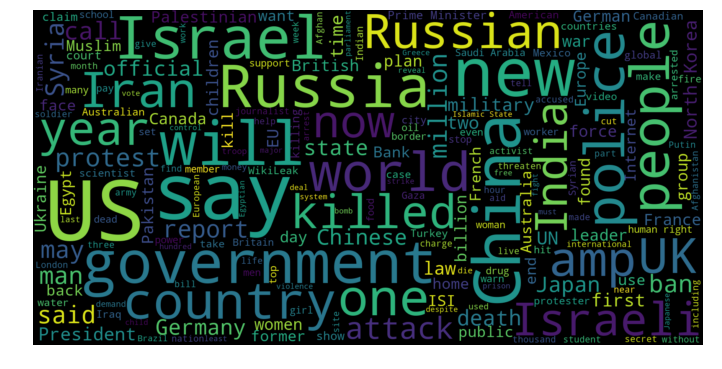

In [20]:
wordcloud = WordCloud(width=1600, height=800, max_font_size=200).generate(neg_text)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [21]:
pos_idx = y_train[y_train == 1].index.values.tolist()
pos_phrases = X_train.loc[pos_idx].values
pos_words = []
for sentence in pos_phrases:
    for t in sentence:
        pos_words.append(t)
pos_words[5]

'Hundreds of lawyers take to the streets in full courtroom attire in protest of unconsitutional Quebec law Syrian diplomats expelled from countries around the world after new massacre France Germany Italy Spain Canada Britain and Australia kick out ambassadors and other senior representatives A New Zealand court has ruled that the US Government must hand over the evidence they have against Megaupload so Kim Dotcom and other employees can properly defend themselves against the pending extradition request The father of a man killed in the  Tiananmen Square crackdown has hanged himself in protest after two decades of failed attempts to seek government redress a support group said Monday BC police gun down a mentally ill man while he crawls on his hands and knees Italy hit by magnitude  earthquake  miles northeast of Parma US denies North Korea commando operation The Gem of Canadian Science that Canadian PM Harper Killed world famous Experimental Lakes Area proved phosphates caused lake ki

In [22]:
pos_text = pd.Series(pos_words).str.cat(sep=' ')
pos_text[:100]

' Earthquake strikes Iran  People killed in Explosions in Iraq Boston Marathon explosions dozens woun'

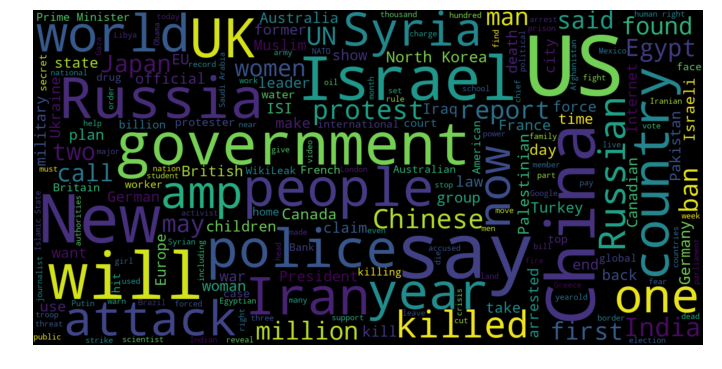

In [23]:
wordcloud = WordCloud(width=1600, height=800, max_font_size=200).generate(pos_text)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

1.5 Term visualization

In [24]:
len(X_train.dropna().values.flatten())

1096

In [25]:
# Lowers all words and removes any numbers from terms
cv = CountVectorizer(stop_words='english', max_features=10000, lowercase=True, token_pattern=r'\b[^\d\W]+\b')
cv.fit(X_train.dropna().values.flatten())

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=10000, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words='english',
                strip_accents=None, token_pattern='\\b[^\\d\\W]+\\b',
                tokenizer=None, vocabulary=None)

In [26]:
neg_matrix=cv.transform(clean_df[clean_df.Label == 0].Combined)
neg_words = neg_matrix.sum(axis=0)
neg_words_freq = [(word, neg_words[0, idx]) for word, idx in cv.vocabulary_.items()]
neg_tf = pd.DataFrame(list(sorted(neg_words_freq, key = lambda x: x[1], reverse=True)),columns=['Terms','negative'])
neg_tf = neg_tf.set_index('Terms')

pos_matrix=cv.transform(clean_df[clean_df.Label == 1].Combined)
pos_words = pos_matrix.sum(axis=0)
pos_words_freq = [(word,pos_words[0, idx]) for word, idx in cv.vocabulary_.items()]
pos_tf = pd.DataFrame(list(sorted(pos_words_freq, key = lambda x: x[1], reverse=True)),columns=['Terms','positive'])
pos_tf = pos_tf.set_index('Terms')

term_df = pd.concat([neg_tf, pos_tf], sort=True, axis=1)
term_df['total'] = term_df['negative']+term_df['positive']
term_df = term_df.sort_values(by='total', ascending=False)
term_df.head(15)

,negative,positive,total
says,1028,1247,2275
new,1007,1092,2099
government,754,894,1648
police,758,853,1611
china,726,868,1594
people,721,792,1513
world,695,750,1445
israel,596,754,1350
years,630,715,1345
russia,595,677,1272


Attempted to see if there was a strong correlation between certain words that could indicate a positive/negative result in the stock market but there was no defining word visually

In [28]:
nonzero=term_df[term_df['negative'] != 0]
nonzero=nonzero[nonzero['positive'] != 0]


# Use ratio to determine better correlation between
nonzero['ratio'] = nonzero['positive'] / nonzero['negative']
nonzero = nonzero.sort_values(by='ratio', ascending=True)
nonzero.head(15)

,negative,positive,total,ratio
netflix,11,1,12,0.090909
cheering,10,1,11,0.100000
shed,10,1,11,0.100000
stomach,10,1,11,0.100000
airways,10,1,11,0.100000
flesh,9,1,10,0.111111
lunar,9,1,10,0.111111
detects,9,1,10,0.111111
programmes,9,1,10,0.111111
lecture,8,1,9,0.125000


1.6 Use Modeling to determine features

In [142]:
train_text = X_train.dropna().values.flatten()
test_text = X_test.dropna().values.flatten()
cv2 = CountVectorizer(stop_words='english',max_features=10000, lowercase=True, ngram_range=(3,3))
cv_train_features = cv2.fit_transform(train_text)

In [143]:
traincv_df = pd.DataFrame(cv_train_features.toarray(), columns=list(cv2.get_feature_names()))
traincv_df.head()

,aa aa india,aaa credit rating,abbott pledges support,abbotts business adviser,abc news australian,abducted women children,abducted women girls,abe said monday,abolish death penalty,abortion gay marriage,...,young people years,yoweri museveni said,yr old afghan,yulin dog meat,zealand oil spill,zealand prime minister,zetas drug cartel,zika virus outbreak,zimbabwe arrested watching,zimbabwe president robert
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [144]:
traincv_df.shape

(1096, 10000)

In [190]:
model = LogisticRegression(solver='liblinear', penalty='l1')
model = model.fit(traincv_df, y_train)

In [191]:
cv_test_features = cv2.transform(test_text)
cv_predictions = model.predict(cv_test_features)

In [192]:
pd.crosstab(y_test, cv_predictions, rownames=["Actual"], colnames=["Predicted"])

Predicted,0,1
Actual,,
0,65,178
1,83,214


In [193]:
accuracy = accuracy_score(cv_predictions,y_test)
accuracy

0.5166666666666667

1.6 Feature Extraction using TF-IDF

In [156]:
tv = TfidfVectorizer(min_df=0.0, max_df=1.0, ngram_range=(1,2),
                     sublinear_tf=True)
tv_train_features = tv.fit_transform(train_text)

In [163]:
traintv_df = pd.DataFrame(tv_train_features.toarray(), columns=list(tv.get_feature_names()))
traintv_df.head()

,aa,aa from,aa india,aa pakistan,aaa,aaa credit,aaa huge,aaa rating,aabo,aabo was,...,zurich police,zurich will,zwanziger,zwanziger has,zweimal,zweimal hitler,zygi,zygi naval,zyklon,zyklon the
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [210]:
tv_model = LogisticRegression(solver='liblinear')
tv_model = tv_model.fit(traintv_df, y_train)

In [211]:
tv_test_features = tv.transform(test_text)
tv_predictions = tv_model.predict(tv_test_features)

In [212]:
pd.crosstab(y_test, tv_predictions, rownames=["Actual"], colnames=["Predicted"])

Predicted,0,1
Actual,,
0,4,239
1,6,291


In [213]:
accuracy = accuracy_score(tv_predictions,y_test)
accuracy

0.5462962962962963

In [ ]:

cache_dir = os.path.join("./cache", "sentiment_analysis")  # where to store cache files
os.makedirs(cache_dir, exist_ok=True)  # ensure cache directory exists

def preprocess_data(data_train, data_test, labels_train, labels_test,
                    cache_dir=cache_dir, cache_file="preprocessed_data.pkl"):
    """Convert each review to words; read from cache if available."""

    # If cache_file is not None, try to read from it first
    cache_data = None
    if cache_file is not None:
        try:
            with open(os.path.join(cache_dir, cache_file), "rb") as f:
                cache_data = pickle.load(f)
            print("Read preprocessed data from cache file:", cache_file)
        except:
            pass  # unable to read from cache, but that's okay
    
    # If cache is missing, then do the heavy lifting
    if cache_data is None:
        # Preprocess training and test data to obtain words for each review
        words_train = []
        for idx, row in data_train.head(n=2).iterrows():
            for article in row:
                words_train.append(article_to_words(article))

        words_test = []
        for idx, row in data_test.head(n=2).iterrows():
            for article in row:
                words_test.append(article_to_words(article))
        
        # Write to cache file for future runs
        if cache_file is not None:
            cache_data = dict(words_train=words_train, words_test=words_test,
                              labels_train=labels_train, labels_test=labels_test)
            with open(os.path.join(cache_dir, cache_file), "wb") as f:
                pickle.dump(cache_data, f)
            print("Wrote preprocessed data to cache file:", cache_file)
    else:
        # Unpack data loaded from cache file
        words_train, words_test, labels_train, labels_test = (cache_data['words_train'],
                cache_data['words_test'], cache_data['labels_train'], cache_data['labels_test'])
    
    return words_train, words_test, labels_train, labels_test

In [ ]:
def build_dict(data, vocab_size = 5000):
    """Construct and return a dictionary mapping each of the most frequently appearing words to a unique integer."""
    
    """ PS tokenize_sentences """
    words = []
    for sentence in data:
        words.extend(sentence)
    words = sorted(list(set(words)))
    print(len(words))
    
    word_count = {} # A dict storing the words that appear in the reviews along with how often they occur
    
    """ PS bag of words """
    word_count = dict.fromkeys(words, 0)
    for sentence in data:
        for sw in sentence:
            word_count[sw] += 1

    # TODO: Sort the words found in `data` so that sorted_words[0] is the most frequently appearing word and
    #       sorted_words[-1] is the least frequently appearing word.
    sorted_words = None
    sorted_words = [i[0] for i in sorted(word_count.items(), key = lambda kv:(kv[1], kv[0]),reverse=True)]
    
    word_dict = {} # This is what we are building, a dictionary that translates words into integers
    for idx, word in enumerate(sorted_words[:vocab_size - 2]): # The -2 is so that we save room for the 'no word'
        word_dict[word] = idx + 2                              # 'infrequent' labels
        
    return word_dict

In [ ]:
word_dict = build_dict(train_X)

In [ ]:
for x in list(word_dict)[0:5]:
    print ("key: %s, value: %d" % (x, word_dict[x]))

In [ ]:
data_dir = './data/pytorch' # The folder we will use for storing data
if not os.path.exists(data_dir): # Make sure that the folder exists
    os.makedirs(data_dir)

In [ ]:
with open(os.path.join(data_dir, 'word_dict.pkl'), "wb") as f:
    pickle.dump(word_dict, f)

In [ ]:
def convert_and_pad(word_dict, sentence, pad=500):
    NOWORD = 0 # We will use 0 to represent the 'no word' category
    INFREQ = 1 # and we use 1 to represent the infrequent words, i.e., words not appearing in word_dict
    
    working_sentence = [NOWORD] * pad
    
    for word_index, word in enumerate(sentence[:pad]):
        if word in word_dict:
            working_sentence[word_index] = word_dict[word]
        else:
            working_sentence[word_index] = INFREQ
            
    return working_sentence, min(len(sentence), pad)

def convert_and_pad_data(word_dict, data, pad=500):
    result = []
    lengths = []
    
    for sentence in data:
        converted, leng = convert_and_pad(word_dict, sentence, pad)
        result.append(converted)
        lengths.append(leng)
        
    return np.array(result), np.array(lengths)